In [2]:
from pathlib import Path
import pickle

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

In [4]:
methods = {
    'sgd-rb-1': ('ogd', "olive", "dashdot"),
    # 'sgd-rb-2': ('r-sgd-2', plt.cm.Greens(0.3), "dashdot"),
    # 'sgd-rb-5': ('r-sgd-5', plt.cm.Greens(0.45), "dashdot"),
    'sgd-rb-10': ('r-sgd-10', plt.cm.Greens(0.9), "dashdot"),
    # 'sgd-rb-20': ('r-sgd-20', plt.cm.Greens(0.75), "dashdot"),
    # 'sgd-rb-50': ('r-sgd-50', plt.cm.Greens(0.9), "dashdot"),
    
    'adam-rb-1': ('r-adam-1', plt.cm.Reds(0.5), "--"),
    # 'adam-rb-2': ('r-adam-2', plt.cm.Reds(0.3), "--"),
    # 'adam-rb-5': ('r-adam-5', plt.cm.Reds(0.45), "--"),
    'adam-rb-10': ('r-adam-10', plt.cm.Reds(0.9), "--"),
    # 'adam-rb-20': ('r-adam-20', plt.cm.Reds(0.75), "--"),
    # 'adam-rb-50': ('r-adam-50', plt.cm.Reds(0.9), "--"),
    
    'fdekf': ('fdekf', 'black', "dotted"),
    'vdekf': ('vdekf', 'dimgray', "dotted"),
    
    'lofi-1': ('lofi-01', plt.cm.Blues(0.5), "-"),
    # 'lofi-2': ('lofi-02', plt.cm.Blues(0.3), "-"),
    # 'lofi-5': ('lofi-05', plt.cm.Blues(0.45), "-"),
    'lofi-10': ('lofi-10', plt.cm.Blues(0.9), "-"),
    # 'lofi-20': ('lofi-20', plt.cm.Blues(0.75), "-"),
    # 'lofi-50': ('lofi-50', plt.cm.Blues(0.9), "-"),
}

n_iter = 100

# Figure 1(b), Figure 18(b)

In [ ]:
# Set environmental variables
%env REBAYES_OUTPUT=./stationary-2000/f-mnist/mlp
%env REBAYES_CONFIG=../configs/

# Run the script
# # To tune the hyperparameters:
# %run ../../run_classification_experiments.py --problem rotated \
#     --ranks 1 10 --dataset f-mnist --verbose 1 --model mlp --tune --n_explore 10 \
#     --n_exploit 15 --n_iter 100
%run ../../run_classification_experiments.py --problem rotated \
    --ranks 1 10 --dataset f-mnist --model mlp --n_iter 100

In [5]:
path_fmnist_mlp = Path(Path.cwd(), "rotated-2000", "f-mnist", "mlp")

agents_fmnist_mlp = (
    *[f"sgd-rb-{rank}" for rank in [1, 10,]],
    *[f"adam-rb-{rank}" for rank in [1, 10,]],
    "fdekf", 
    "vdekf",
    *[f"lofi-{rank}" for rank in [1, 10,]],
)

results_miscl_fmnist_mlp, results_nll_fmnist_mlp = {}, {}

for method in agents_fmnist_mlp:
    with open(Path(path_fmnist_mlp, f'{method}.pkl'), "rb") as f:
        curr_result = pickle.load(f)
    results_miscl_fmnist_mlp[method] = {
        "mean": jnp.mean(curr_result["window-miscl"], axis=0),
        "std": jnp.std(curr_result["window-miscl"], axis=0),
    }
    results_nll_fmnist_mlp[method] = {
        "mean": jnp.mean(curr_result["window-nll"], axis=0),
        "std": jnp.std(curr_result["window-nll"], axis=0),
    }

In [6]:
kernel_size = 20
kernel = jnp.ones((kernel_size,)) / kernel_size
convolve = lambda x: jnp.convolve(x, kernel, mode='same')

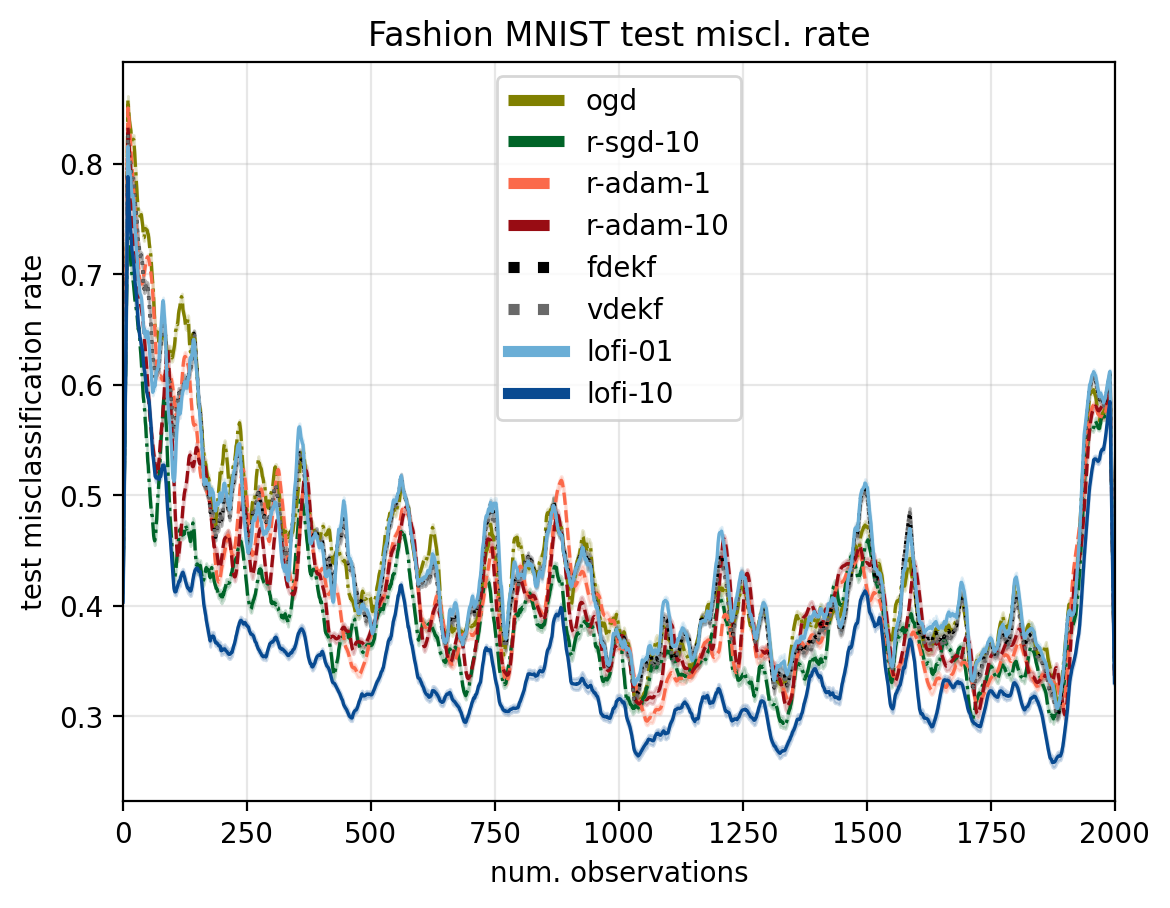

In [8]:
# Misclassification rate
fig, ax = plt.subplots()
for key, val in results_miscl_fmnist_mlp.items():
    mean, std = convolve(val['mean']), val['std']
    label, color, ls = methods[key]
    ax.plot(mean, label=label, c=color, linewidth=1.2, linestyle=ls)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.2,
        color=color
    )
ax.set_xlabel('num. observations')
ax.set_ylabel('test misclassification rate')
ax.set_xlim(0, 2000)
# ax.set_ylim(0.2, 0.6)
ax.grid(alpha=0.3)
ax.set_title('Fashion MNIST test miscl. rate')
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)

fig.savefig(Path(path_fmnist_mlp, 'fmnist-mlp-clf-test-miscl.pdf'), bbox_inches='tight')

# Figure 18(a)

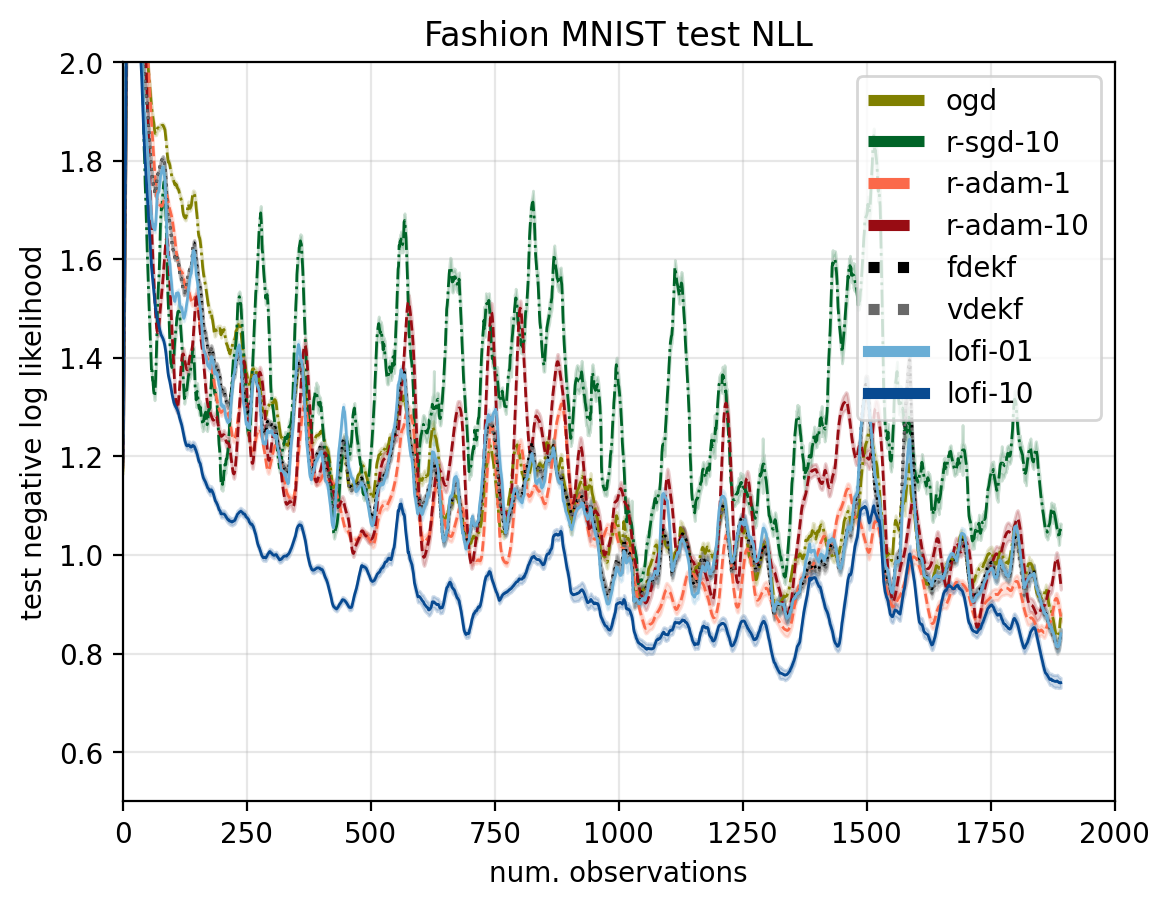

In [10]:
# Negative log-likelihood
fig, ax = plt.subplots()
for key, val in results_nll_fmnist_mlp.items():
    mean, std = convolve(val['mean']), val['std']
    label, color, ls = methods[key]
    ax.plot(mean, label=label, c=color, linewidth=1.0, linestyle=ls)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.2,
        color=color
    )
ax.set_xlabel('num. observations')
ax.set_ylabel('test negative log likelihood')
ax.set_xlim(0, 2000)
ax.set_ylim(0.5, 2.0)
ax.grid(alpha=0.3)
ax.set_title('Fashion MNIST test NLL')
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)

fig.savefig(Path(path_fmnist_mlp, 'fmnist-mlp-clf-test-nll.pdf'), bbox_inches='tight')